# 0. Dependências

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from scipy import linalg

%matplotlib inline
pd.options.display.max_rows = 10

# 1. Introdução 

A ***Linear Discriminant Analsysis (LDA)*** é uma técnica muito utilizada para redução de dimensionalidade na etapa de pré-processamento em aplicações de reconhecimento de padrões e aprendizagem de máquina. **O objetivo é projetar o dataset em um espaço de menor dimensões com uma boa separação das classes para evitar overfitting e reduzir o custo computacional**.

A abordagem do LDA é bem semelhante a do PCA, no entanto, **além de encontrar os componentes que maximizam a variância dos nossos dados (PCA), nós também estamos interessados nos componentes que maximizam a separação entre múltiplas classes (LDA)**.

Resumindo, o objetivo do LDA é projetar um espaço de atributos (um banco de dados com amostras n-dimensional) em um subespaço menor ***k*** (onde $k \leq n-1$) mantendo a informação de discriminação das classes.

Em geral, a redução de dimensionalidade ajuda não somente a reduzir custos computacionais para um dado problema de classificação, mas também é útil para evitar o overfitting pela minimização do erro na estimação de parâmetros.

## PCA vs LDA

Ambos PCA e LDA são técnicas de transformações lineares bastante utilizadas para redução de dimensionalidade. Por um lado, o PCA pode ser descrito como um algoritmo "não-supervisionado", já que ele "ignora" os rótulos das classes e seu objetivo é encontrar as direções (componentes principais) que maximizam a variância no banco de dados. Por outro lado, o LDA é "supervisionado" e calcula as direções (discriminantes lineares) que vão representar os eixos que maximizam a separação entre múltiplas classes.

Embora pareça que o LDA seja superior ao PCA em problemas de multi-classificação onde os rótulos das classes são conhecidos, nem sempre isso acontece. Por exemplo, comparações entre acurácias de classificação para reconhecimento de imagens após o uso de PCA ou LDA mostra que **o PCA tende a ser melhor que o LDA se o número de amostras/classe é relativamente pequeno** (<a href="http://ieeexplore.ieee.org/xpl/articleDetails.jsp?arnumber=908974">PCA vs LDA</a>, A.M. Martinez et al., 2001). Na prática, também é comum usar ambos LDA e PCA em conjunto, isto é, PCA para redução de dimensionalidade seguido por um LDA.

<img src="images/PCAvsLDA.png" width=600>

### O que é um "bom" subespaço?

Supondo que nosso objetivo é reduzir as dimensões de um dataset ***d***-dimensional pela projeção em um subespaço ***k***-dimensional (onde ***k < d***). Então, como saber qual tamanho devemos escolher para ***k*** (***k*** = o número de dimensões do novo subespaço de atributos), e como saber se nós temos um espaço de atributos que representa "bem" nossos dados?

Em breve, nós vamos calcular os autovetores (componentes) do nosso dataset e coletá-los em matrizes chamadas *matrizes-esparsas (scatter-matrizes)*, ou melhor, matrizes esparsas intra-classes e inter-classes. Cada um desses autovetores é associado a um autovalor que nos diz o "tamanho" ou "magnitude" dos autovetores.

**Se observamos que todos autovalores tem uma magnitude similar, então isso pode ser um bom indicador que nossos dados já estão projetados em um "bom" espaço de atributos.**

Por outro lado, se alguns autovalores tem a magnitude muito maior que a dos outros, devemos escolher seus autovetores já que eles contém mais informação sobre a distribuição dos nossos dados. Da mesma forma, autovalores próximos a zero são menos informativos e devemos desconsiderá-los na construção do nosso subespaço.

## Aplicação

Em geral, a aplicação do LDA envolve a aplicação dos seguintes passos:
1. Calcular a média (vetor **d**-dimensional) para cada uma das classes do dataset
2. Calcular as scatter-matrices (intra-classe e inter-classe)
3. Calcular os autovetores ($e_1, e_2, ..., e_d$) e seus correspondentes autovalores ($\lambda_1, \lambda_2,...\lambda_d$) para as scatter-matrices.
4. Ordenar os autovetores pelos autovalores em ordem decrescente e escolher os ***k*** autovetores com os maiores autovalores para formar uma matriz **W** [$d \times k$], onde cada coluna representa um autovetor.
5. Usar **W** para transformar as amostras no novo subespaço. Isso pode ser resumido pela multiplicação de matrizes: $Y = X \times W$ (onde **X** [$n \times d$] é a matriz que representa nosso dataset com ***n*** amostras, e **Y** é matriz das amostras transformadas no novo subespaço [$n \times k$]).

## Suposições de Normalidade

Assim como outros algoritmos, o LDA assume que os dados são normalmente distribuidos, os atributos são estatisticamente independentes e matriz de covariância idênticas para cada classe. Entretanto, isso só se aplica ao LDA como classificador. Como redutor de dimensionalidade, o LDA também funciona razoavelmente bem se essas suposições forem violadas. E mesmo para tarefas de classificação o LDA pode ser robusto a distribuição dos dados:

> “linear discriminant analysis frequently achieves good performances in the tasks of face and object recognition, even though the assumptions of common covariance matrix among groups and normality are often violated (Duda, et al., 2001)” <a href="http://link.springer.com/article/10.1007%2Fs10115-006-0013-y">(Tao Li, et al., 2006)</a>.

O escalamento de atributos (como padronização) **não** afeta os resultados gerais de um LDA e, portanto, pode ser opcional. Obviamente, as matrizes scatter vão ser diferentes dependendo se os atributos foram normalizados ou não. Além disso, os autovetores vão ser diferentes também. Entretanto, a parte importante é que os autovalores vão ser exatamente os mesmos como também as projeções finais - a única diferença que você notará é a escala dos eixos. Isso pode ser mostrado matematicamente (trabalhos futuros) e você pode encontrar nas referências a demonstração prática.

## Algoritmo

### Passo 1: Calcular os médios d-dimensionais

Vamos começar calculando os vetores médios **$\mu$** de cada atributos para todas as amostras de cada classe $C$ presente nos nossos dados. Logo, o vetor $\mu$ terá $C$ linhas (#classes) e $F$ linhas (#atributos).

### Passo 2: Calcular as Scatter Matrices

A matriz scatter **intra-classe** $S_W$ é calculada pela seguinte equação:

$$S_W = \sum_{c=1}^{C} \frac{1}{N_c} (x_c - \mu_c)^T(x_c - \mu_c)$$

Onde $N_c$ é a #amostra de uma determinada classe $c$

Repare que $(x_c - \mu_c)^T(x_c - \mu_c)$ representa o cálculo da **matriz de covariância**. Repare também que descartar o termo $\frac{1}{N_c}$, apenas deixa matriz resultante descalonada. **Entretanto, o autoespaçoes resultantes seriam os mesmos (mesmo autovetores, somente os autovalores seriam diferentemente escalados por um fator constante)**.

A scatter matrix **entre-classes** $S_B$ é calculada pela seguinte equação:

$$S_B =  \sum_{c=1}^{c} \frac{1}{N_c} (\mu_c - \bar x)^T(\mu_c - \bar x)$$

Onde $\bar x$ representa a média de todas as amostras por atributo.

Uma vez que $S_W$ representa a matriz *intra-classe* e a covariância total (de todas as amostras) é dada por $S_T$, você também pode calcular $S_B = S_T - S_W$. 

### Passo 3: Cálculo dos autovalores para a matriz $S_W^{-1} S_B$

Os autovalores e o autovetores são calculados a partir da seguinte fórmula:

$$S_W^{-1} S_B$$

A título de recordação, ambos autovetores e autovalores nos dão informações a respeito da distorção em uma transformação linear: os **autovetores são basicamente a direção dessa distorção**, enquanto os **autovalores representam o fator de escala para os autovetores que descrevem a magnitude da distorção**.

Se estamos aplicando o LDA para redução de dimensionalidade, os autovetores são importantes uma vez que eles vão formar os novos eixos do novo subespaço de atributos; os autovalores associados são particularmente importantes pois nos dizem quão "informativos" os novos eixos são.

#### Verificação dos autovetores e autovalores

Podemos verificar os nosso autovetores e autovalores calculados pela verificação da seguinte equação:

$$Av = \lambda v$$

onde,
$$A = S_W^{-1}S_B$$
$$v = autovetor$$
$$\lambda = autovalor$$

### Passo 4: Selecão dos discriminantes lineares

Não estamos interessado em somente projetar os dados em um subespaço que aumenta a separação entre as classes, mas também reduzir a dimensionalidade do nosso espaço de atributos. Entretanto, os autovetores somente definem as direções dos novos eixos, já que todos são vetores unitários.

Logo, para decidir quai(s) autovetor(es) nós escolheremos, iremos olhar os autovalores correspondentes de cada autovetor. De maneira geral, vamos mantes os autovetores com os maiores autovalores associados a eles.

A maneira mais comum de fazer isso é ordenar os autovalores em ordem decrescente e escolher os top-k autovetores associados.

# 2. Dados

Nesse tutorial, vamos utilizar o **Iris dataset**, já presente no scikit-learn. O Iris dataset contém dados de 150 flores divididas em 3 espécies diferentes (setosa, versicolor, virginica). Os dados são:

1. sepal lenght em cm
2. sepal width em cm
3. petal length em cm
4. petal width em cm

<img src="images/Iris-dataset.png" width=400>

In [2]:
iris = load_iris()

df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['class'] = iris.target
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [3]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [4]:
x = df.drop(labels='class', axis=1).values
y = df['class'].values

print(x.shape, y.shape)

(150, 4) (150,)


# 3. Implementação 

In [5]:
class LDA():
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.priors_ = None
        self.means_ = []
        self.covariance_ = []
        self.overall_mean = 0.0
        self.eigen_values = None
        self.eigen_vectors = None

    def fit(self, x, y):
        classes = np.unique(y)
        n_classes = len(classes)
        _, n_features = x.shape
        self.priors_ = np.bincount(y) / float(len(y))
        self.max_components = n_classes - 1 if self.n_components is None else np.clip(self.n_components, 1, n_classes - 1)

        # Passo 1: calcular os vetores médios para cada classe
        self.means_ = np.array([np.mean(x[y == c], axis=0) for c in classes])

        # Passo 2: calcular as scatter matrices
        self.covariance_ = np.sum([p * np.cov(x[y == c], rowvar=False, bias=1) for p, c in zip(self.priors_, classes)], axis=0)
        S_w = self.covariance_
        S_t = np.cov(x.T, bias=1)
        S_b = S_t - S_w

        # Passo 3: calcular os autovalores e autovetores
        self.eigen_values, self.eigen_vectors = np.linalg.eig(np.linalg.inv(S_w).dot(S_b))
        self.eigen_vectors *= -1

        # Passo 4: seleção dos discriminantes lineares
        self.sorted_components_ = np.argsort(self.eigen_values)[::-1]

        self.projection_matrix_ = self.eigen_vectors[:, self.sorted_components_[:self.max_components]]

        self.explained_variance_ = self.eigen_values[self.sorted_components_]
        self.explained_variance_ratio_ = self.explained_variance_ / self.eigen_values.sum()

    def predict(self, x):
        cov_inv = np.linalg.inv(self.covariance_)

        discriminants = []
        for p, mean_vec in zip(self.priors_, self.means_):
            first_term = np.dot(x, cov_inv).dot(mean_vec.T).reshape(-1, 1)
            second_term = 0.5 * (np.dot(mean_vec, cov_inv).dot(mean_vec.T))
            discriminants.append(first_term - second_term + np.log(p))

        discriminants = np.hstack(discriminants)
        return np.argmax(discriminants, axis=1)

    def transform(self, x):
        return np.dot(x, self.projection_matrix_)

# 4. Teste 

In [6]:
lda = LDA()
lda.fit(x, y)

print(lda.means_)
print(lda.covariance_)
print(lda.eigen_vectors)
print(lda.explained_variance_ratio_)

[[5.006 3.428 1.462 0.246]
 [5.936 2.77  4.26  1.326]
 [6.588 2.974 5.552 2.026]]
[[0.259708   0.09086667 0.164164   0.03763333]
 [0.09086667 0.11308    0.05413867 0.032056  ]
 [0.164164   0.05413867 0.181484   0.041812  ]
 [0.03763333 0.032056   0.041812   0.041044  ]]
[[ 0.20874182  0.00653196 -0.46181729  0.48837016]
 [ 0.38620369  0.58661055 -0.13524437 -0.44139262]
 [-0.55401172 -0.25256154 -0.20708899 -0.48752096]
 [-0.7073504   0.76945309  0.851791    0.5735769 ]]
[ 9.91212605e-01  8.78739503e-03  2.86565299e-16 -6.81510971e-16]


In [7]:
x_proj = lda.transform(x)
y_pred = lda.predict(x[::15])

print(x_proj[:5])
print(y_pred)

[[1.49920971 1.88675441]
 [1.2643595  1.59214275]
 [1.35525305 1.73341462]
 [1.18495616 1.62358806]
 [1.5169559  1.94476227]]
[0 0 0 0 1 1 1 2 2 2]


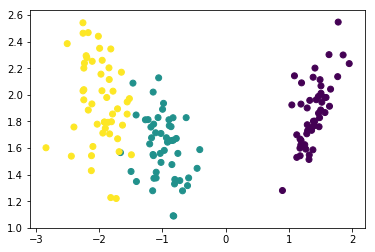

In [8]:
plt.scatter(x_proj[:, 0], x_proj[:, 1], c=y)

## Comparação com o Scikit-learn

In [9]:
lda_sk = LinearDiscriminantAnalysis(solver='eigen', store_covariance=True)
lda_sk.fit(x, y)

print(lda_sk.means_)
print(lda_sk.covariance_)
print(lda_sk.scalings_)
print(lda_sk.explained_variance_ratio_)

[[5.006 3.428 1.462 0.246]
 [5.936 2.77  4.26  1.326]
 [6.588 2.974 5.552 2.026]]
[[0.259708   0.09086667 0.164164   0.03763333]
 [0.09086667 0.11308    0.05413867 0.032056  ]
 [0.164164   0.05413867 0.181484   0.041812  ]
 [0.03763333 0.032056   0.041812   0.041044  ]]
[[ 0.20874182  0.00653196 -0.52465543  0.44550654]
 [ 0.38620369  0.58661055 -0.09851721 -0.43741869]
 [-0.55401172 -0.25256154 -0.1686191  -0.48676231]
 [-0.7073504   0.76945309  0.82861248  0.61094294]]
[0.9912126 0.0087874]


In [10]:
x_proj_sk = lda_sk.transform(x)
y_pred_sk = lda_sk.predict(x[::15])

print(x_proj_sk[:5])
print(y_pred_sk)

[[1.49920971 1.88675441]
 [1.2643595  1.59214275]
 [1.35525305 1.73341462]
 [1.18495616 1.62358806]
 [1.5169559  1.94476227]]
[0 0 0 0 1 1 1 2 2 2]


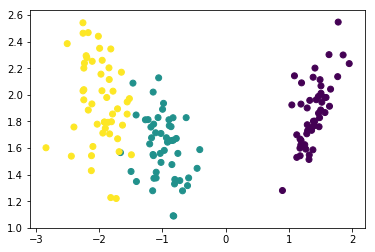

In [11]:
plt.scatter(x_proj_sk[:, 0], x_proj_sk[:, 1], c=y)

## 5. Referências

- [Antigo notebook do LDA com explicação passo-a-passo](https://github.com/arnaldog12/Machine_Learning/blob/a0d4999fc7efc51ce6a44acac9282e8dc512fa45/LDA.ipynb)
- [Implementação Original do Scikit-learn](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/discriminant_analysis.py)
- [Linear Discriminant Analysis](https://sebastianraschka.com/Articles/2014_python_lda.html)
- [Linear discriminant analysis: A detailed tutorial](https://www.researchgate.net/publication/316994943_Linear_discriminant_analysis_A_detailed_tutorial)
- [Classification — Linear Discriminant Analysis](https://towardsdatascience.com/classification-part-2-linear-discriminant-analysis-ea60c45b9ee5)